##### Copyright (C) Microsoft Corporation.  
see license file for details 

In [31]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [32]:
# AZUREML_NATIVE_SHARE_DIRECTORY mapping to host dir is set by _nativeSharedDirectory_ in .compute file 

import os
try:
    amlWBSharedDir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']    
except:
    amlWBSharedDir = ''
    print('not using aml services?')
    
amlWBSharedDir

'/azureml-share/'

In [33]:
# # Use the Azure Machine Learning data collector to log various metrics
# from azureml.logging import get_azureml_logger
# logger = get_azureml_logger()

In [34]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [35]:
%matplotlib inline

In [36]:
# import utlity functions

import sys, os
paths_to_append = [os.path.join(os.getcwd(), os.path.join(*(['Code',  'src'])))]
def add_path_to_sys_path(path_to_append):
    if not (any(path_to_append in paths for paths in sys.path)):
        sys.path.append(path_to_append)
[add_path_to_sys_path(crt_path) for crt_path in paths_to_append]

import azure_chestxray_cam, azure_chestxray_utils, azure_chestxray_keras_utils

[None]

In [37]:
# create the file path variables 

prj_consts = azure_chestxray_utils.chestxray_consts()

data_base_output_dir=os.path.join(amlWBSharedDir, 
                                  os.path.join(*(prj_consts.BASE_OUTPUT_DIR_list)))  
data_base_input_dir=os.path.join(amlWBSharedDir, 
                                 os.path.join(*(prj_consts.BASE_INPUT_DIR_list)))

# "quality" models, fully trained on all training data
fully_trained_weights_dir=os.path.join(data_base_output_dir, 
    os.path.join(*(prj_consts.FULLY_PRETRAINED_MODEL_DIR_list)))
fully_trained_weights_dir
!ls -l {fully_trained_weights_dir}

test_images_dir=os.path.join(data_base_input_dir, 
    os.path.join(*(['test_images'])))
test_images_dir
test_images=azure_chestxray_utils.get_files_in_dir(test_images_dir)
len(test_images)
test_images[0]

nih_chest_xray_data_dir=os.path.join(data_base_input_dir, 
                                     os.path.join(*(prj_consts.ChestXray_IMAGES_DIR_list)))

nih_chest_xray_data_dir
chestXray_images=azure_chestxray_utils.get_files_in_dir(nih_chest_xray_data_dir)
len(chestXray_images)
chestXray_images[0]

'/azureml-share/chestxray/output/fully_trained_models'

total 86320
-rw-rw-r-- 1 1003 1003 30097832 Feb 14 04:37 azure_chest_xray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5
-rw-r--r-- 1 root root 29143128 Feb 14 04:55 weights_only_azure_chest_xray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5
-rw-rw-r-- 1 1003 1003 29142168 Feb  7 06:16 weights_only_azure_chest_xray__14_weights_712split_epoch_029_val_loss_147.7599.hdf5


'/azureml-share/chestxray/data/ChestX-ray8/test_images'

70

'00017802_001.png'

'/azureml-share/chestxray/data/ChestX-ray8/ChestXray-NIHCC'

112120

'00002592_000.png'

In [38]:
# get long (full path) model file name

models_file_name=!ls {os.path.join(fully_trained_weights_dir, '*.hdf5')}
models_file_name

['/azureml-share/chestxray/output/fully_trained_models/azure_chest_xray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5',
 '/azureml-share/chestxray/output/fully_trained_models/weights_only_azure_chest_xray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5',
 '/azureml-share/chestxray/output/fully_trained_models/weights_only_azure_chest_xray__14_weights_712split_epoch_029_val_loss_147.7599.hdf5']

In [39]:
# create densenet model pretrained on imagenet
import keras_contrib
model = azure_chestxray_keras_utils.build_model(keras_contrib.applications.densenet.DenseNetImageNet121)

Weights for the model were loaded successfully


In [40]:
model_summary = model.summary()
# model_summary

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
initial_bn (BatchNormalization) (None, 112, 112, 64) 256         initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_122 (Activation)     (None, 112, 112, 64) 0           initial_bn[0][0]                 
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
dense_2_2_conv2D (Conv2D)       (None, 14, 14, 32)   36864       activation_166[0][0]             
__________________________________________________________________________________________________
concatenate_79 (Concatenate)    (None, 14, 14, 352)  0           concatenate_78[0][0]             
                                                                 dense_2_2_conv2D[0][0]           
__________________________________________________________________________________________________
dense_2_3_bn (BatchNormalizatio (None, 14, 14, 352)  1408        concatenate_79[0][0]             
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 14, 14, 352)  0           dense_2_3_bn[0][0]               
__________________________________________________________________________________________________
dense_2_3_

In [41]:
# replace mode weights with the ones computing by training in chest xray

model_file_name = prj_consts.PRETRAINED_DENSENET201_IMAGENET_CHESTXRAY_MODEL_FILE_NAME
model_file_name = 'weights_only_azure_chest_xray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5'
model.load_weights(os.path.join(fully_trained_weights_dir, model_file_name))

In [42]:
# classify an example image

import cv2
cv2_image = cv2.imread(os.path.join(test_images_dir,test_images[3]))

In [43]:
# get diseases prediction and feature maps used for cam just as FYI
#  a cam image is class_weights[:, some_pathology]*conv_features[:,:,i]

from keras.models import Model

predictions = model.predict(cv2_image[None,:,:,:])
predictions
conv_map_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
conv_features = conv_map_model.predict(cv2_image[None,:,:,:])
conv_features = conv_features[0, :, :, :] #np.squeeze(conv_features)
class_weights = model.layers[-1].get_weights()

array([[8.5960740e-01, 3.5814239e-05, 1.3000718e-03, 5.7725543e-01,
        1.2375477e-03, 2.4678574e-03, 4.9097221e-02, 7.3159980e-03,
        2.1684219e-01, 4.8722052e-03, 7.2677298e-03, 2.3562429e-03,
        1.8120438e-03, 8.6421314e-05]], dtype=float32)

In [44]:
# get diseases prediction and cam

cv2_image = cv2.imread(os.path.join(test_images_dir,test_images[3]))

azure_chestxray_utils.print_image_stats_by_channel(cv2_image)
cv2_image = azure_chestxray_utils.normalize_nd_array(cv2_image)
cv2_image = 255*cv2_image
cv2_image=cv2_image.astype('uint8')
azure_chestxray_utils.print_image_stats_by_channel(cv2_image)

predictions, cam_image, predicted_disease_index = \
azure_chestxray_cam.get_score_and_cam_picture(cv2_image, model)
predictions

prj_consts.DISEASE_list[predicted_disease_index]
print('likely disease: ', prj_consts.DISEASE_list[predicted_disease_index])
print('likely disease prob ratio: ', \
          predictions[predicted_disease_index]/sum(predictions))

min:
0 0 0
max:
242 242 242
min:
0 0 0
max:
255 255 255


array([9.1676521e-01, 2.9064200e-05, 1.9409381e-03, 5.9699917e-01,
       1.0164377e-03, 3.1932192e-03, 4.9693190e-02, 5.7660821e-03,
       2.2952040e-01, 2.6503936e-03, 8.1120105e-03, 3.3133388e-03,
       1.5641104e-03, 7.0999566e-05], dtype=float32)

'Atelectasis'

likely disease:  Atelectasis
likely disease prob ratio:  0.5035415853730187


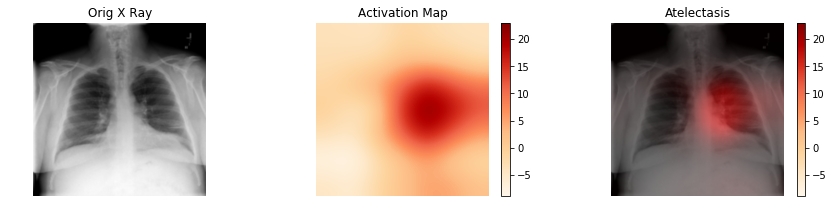

In [45]:
# cam image (overimposed on orig Xray image)

blended_image = azure_chestxray_cam.process_cam_image(cam_image, cv2_image)
azure_chestxray_cam.plot_cam_results(blended_image, cam_image, cv2_image, \
                 prj_consts.DISEASE_list[predicted_disease_index])

predictions:  [5.2463962e-03 1.6679522e-04 1.0298470e-04 2.6574641e-01 1.6688515e-02
 6.5188795e-01 4.1105162e-02 1.9488763e-04 3.9646025e-03 4.6567782e-04
 1.3033558e-04 4.4535600e-02 1.3967488e-03 1.8578835e-06]
likely disease:  Nodule
likely disease prob:  65.18879532814026
likely disease prob ratio:  63.189851928108425
predictions:  [3.1053483e-02 8.3310246e-05 1.3570292e-02 1.2165087e-01 8.0227228e-03
 4.3867883e-01 7.0700189e-03 9.7602169e-05 1.5265471e-03 1.1390158e-05
 6.3054264e-04 2.4071900e-02 1.2002650e-02 9.8635396e-04]
likely disease:  Nodule
likely disease prob:  43.86788308620453
likely disease prob ratio:  66.5212676394256
predictions:  [6.85549527e-02 9.24062988e-06 1.08852284e-02 1.09415077e-01
 1.58228464e-02 9.46373269e-02 6.43160078e-04 1.02188314e-04
 2.09113845e-04 1.31474155e-06 1.70524139e-02 8.60545959e-04
 3.85190756e-03 1.42139615e-04]
likely disease:  Infiltration
likely disease prob:  10.941507667303085
likely disease prob ratio:  33.96006725439269
predic

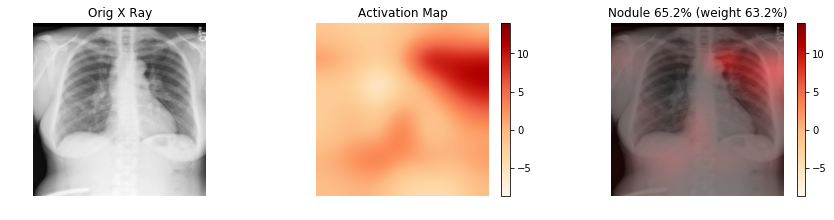

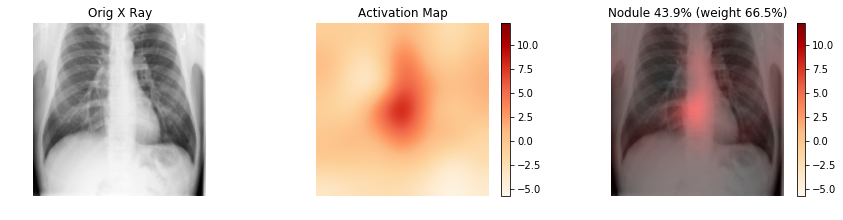

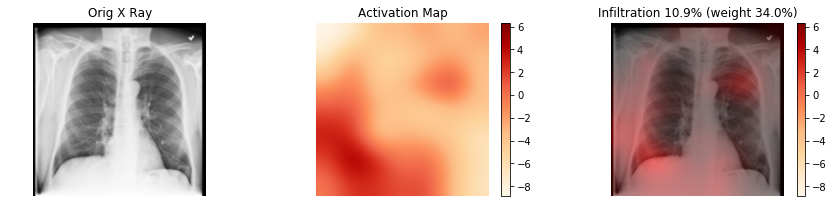

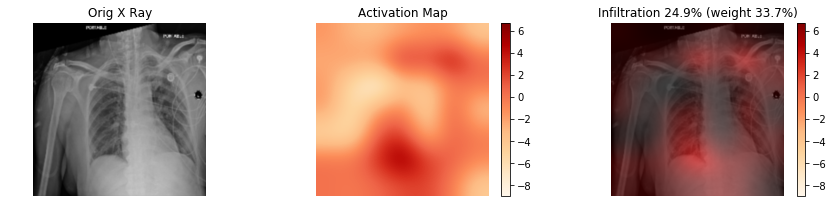

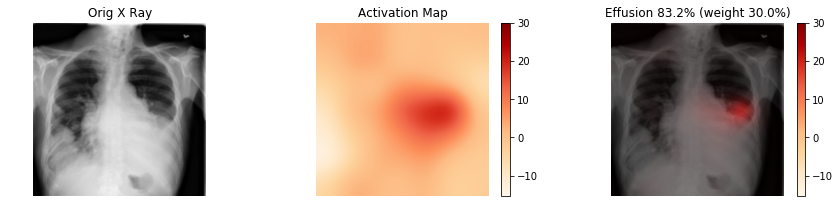

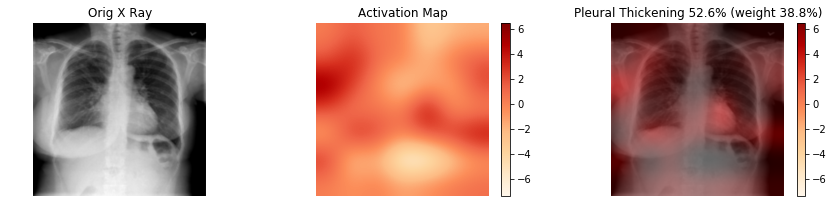

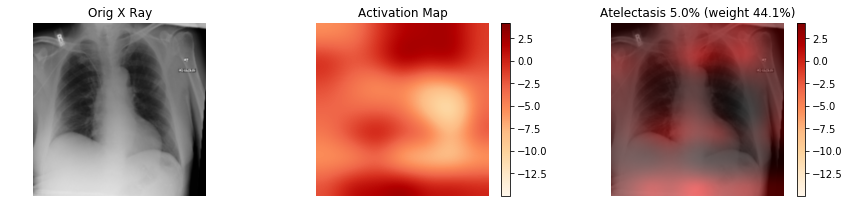

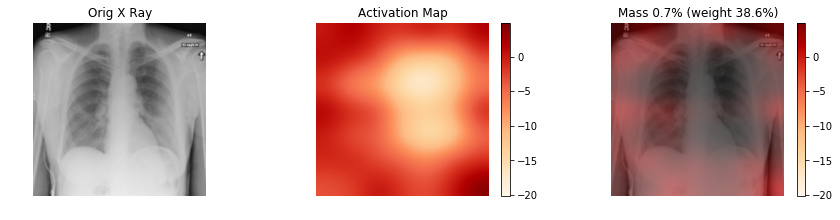

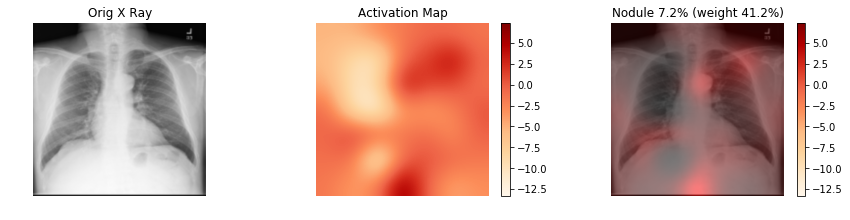

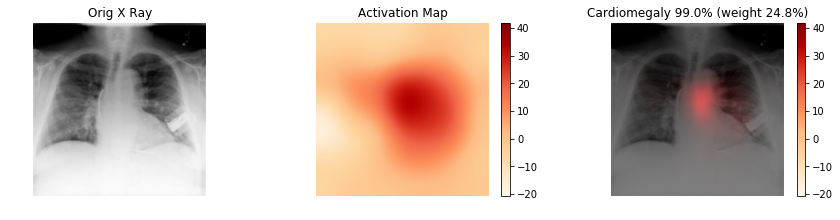

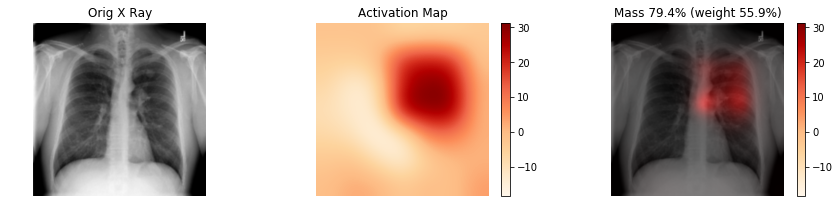

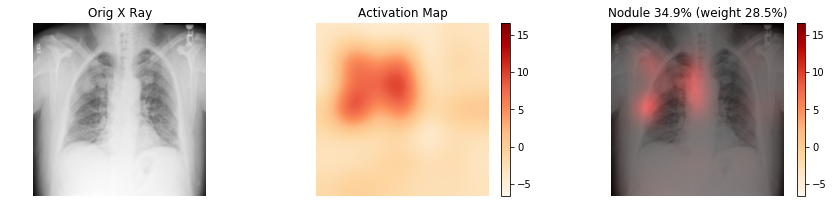

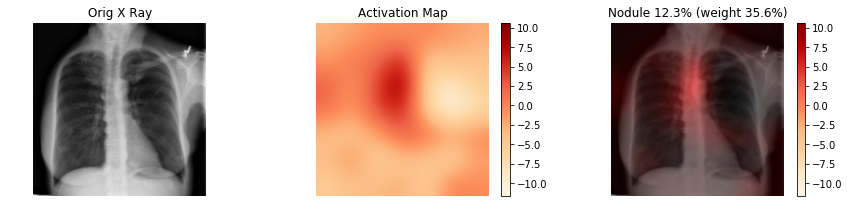

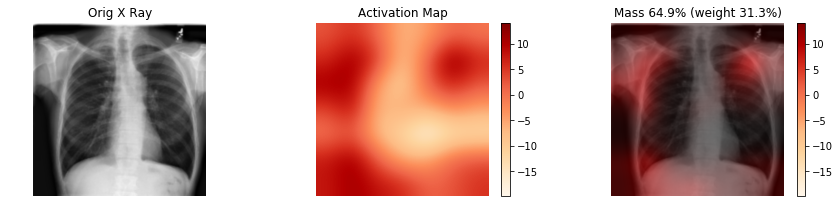

In [46]:
# test some NIH annotated images (not used for training)
NIH_annotated_nodules = ['00001688_000.png', '00004547_003.png',\
                        '00023078_000.png', '00023068_003.png',\
                        '00013911_000.png', '00027927_009.png',\
                        '00014116_009.png', '00019058_004.png',\
                        '00016487_002.png', '00015794_000.png',\
                        '00012374_000.png', '00003948_001.png',\
                        '00018366_000.png','00014778_000.png'\
                        ]
azure_chestxray_cam.process_nih_data(NIH_annotated_nodules, 
                                   nih_chest_xray_data_dir, model)


predictions:  [1.8326892e-02 9.8758578e-01 9.0107131e-01 3.1599018e-01 3.9045583e-02
 9.7507350e-02 1.9420674e-02 5.0983815e-03 1.5818606e-01 8.5278573e-03
 6.6438763e-05 1.8713983e-02 1.1125437e-01 1.0737573e-03]
likely disease:  Cardiomegaly
likely disease prob:  98.75857830047607
likely disease prob ratio:  36.824539947521615
predictions:  [0.02287564 0.16799584 0.15220836 0.20085716 0.01243556 0.00816963
 0.00082877 0.01817592 0.01921533 0.00118014 0.06911842 0.02453131
 0.14334345 0.00020289]
likely disease:  Infiltration
likely disease prob:  20.085716247558594
likely disease prob ratio:  23.87920466377791
predictions:  [4.3931999e-03 8.2341808e-01 4.1341618e-02 1.2847714e-01 1.5097744e-03
 4.5130821e-03 1.0494998e-02 5.9513981e-04 3.4775087e-03 1.8552969e-01
 1.1608670e-04 7.9407782e-04 3.0317280e-04 1.8594241e-05]
likely disease:  Cardiomegaly
likely disease prob:  82.34180808067322
likely disease prob ratio:  68.3344619335418
predictions:  [1.5278961e-01 3.5750661e-02 2.751596

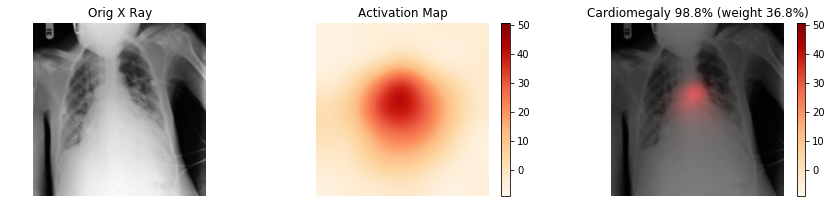

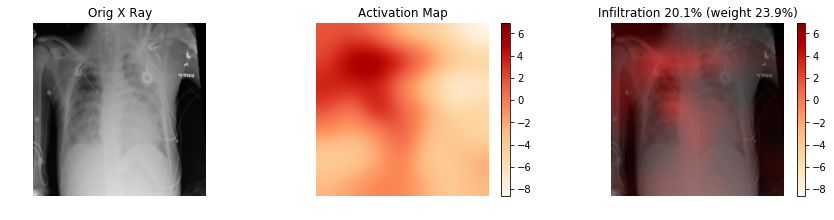

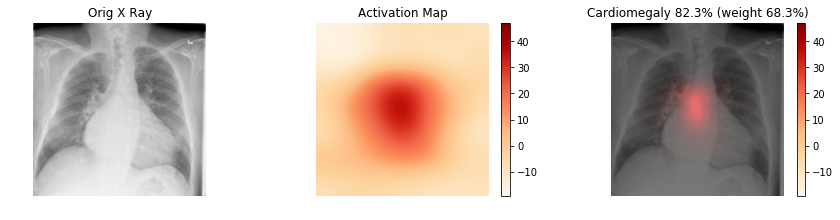

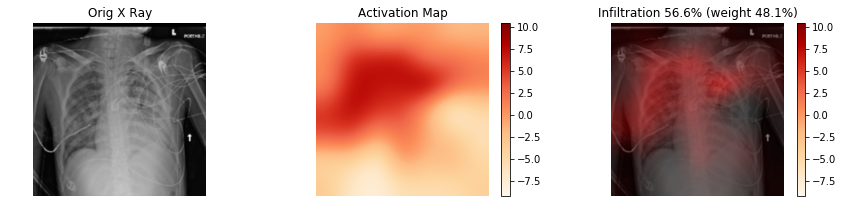

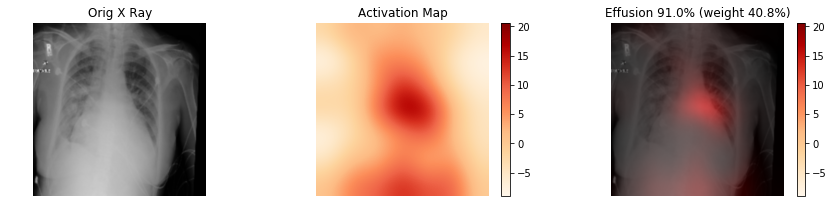

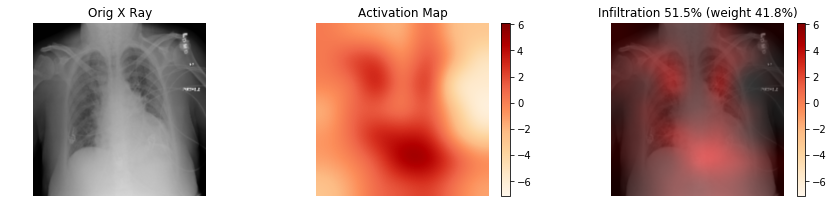

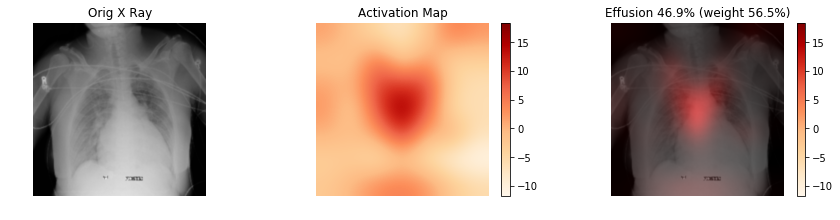

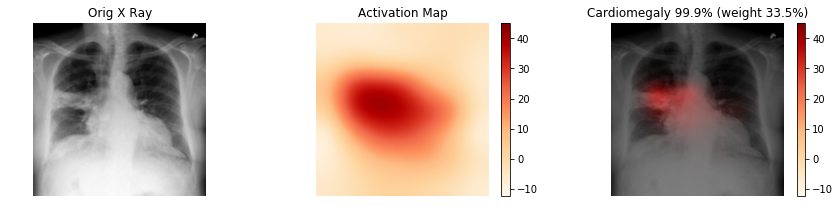

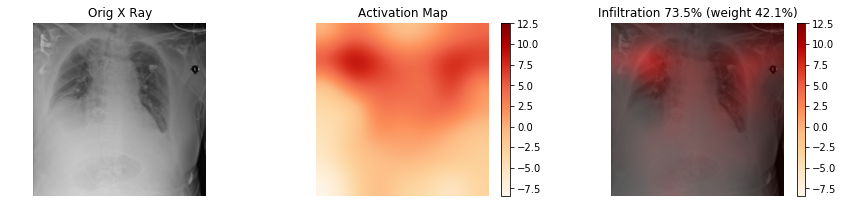

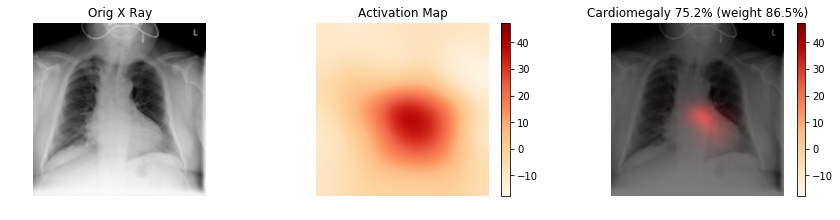

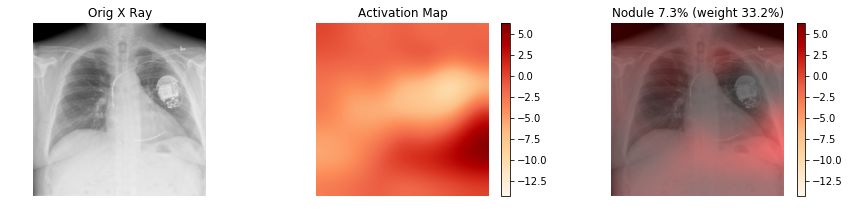

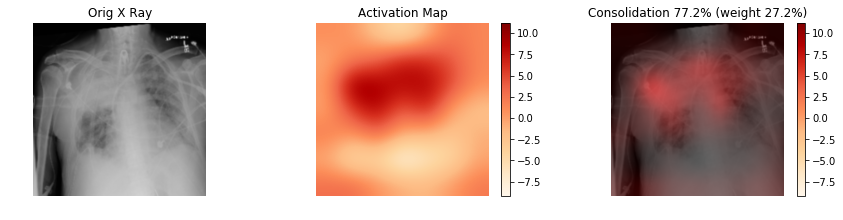

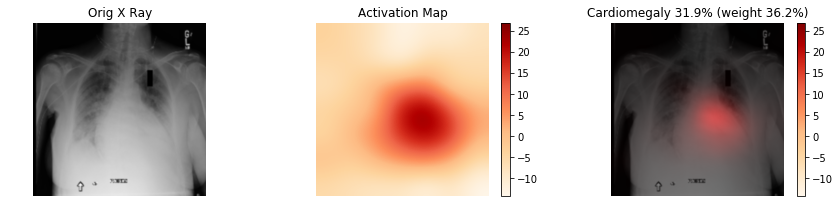

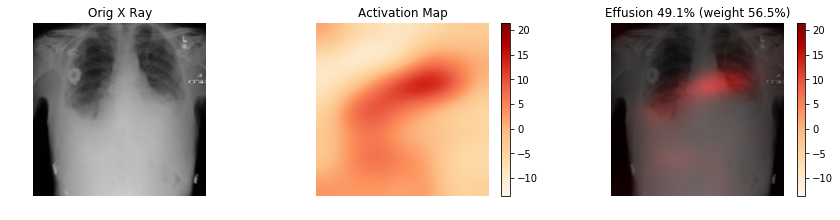

In [47]:
# test some NIH annotated images (not used for training)

NIH_annotated_Cardiomegaly = ['00005066_030.png', '00009608_024.png',\
                        '00000661_000.png', '00019018_007.png',\
                        '00000211_041.png', '00015770_010.png',\
                        '00011463_002.png', '00021364_001.png',\
                        '00003394_006.png', '00016990_000.png',\
                        '00027797_000.png', '00013670_151.png',\
                        '00011322_006.png','00018387_030.png'\
                        ]
azure_chestxray_cam.process_nih_data(NIH_annotated_Cardiomegaly, 
                                     nih_chest_xray_data_dir,
                                     model)

In [48]:
# C:\repos\ChestXRay\TDSP>jupyter nbconvert --to html .\Code\02_Model\040_cam_simple.ipynb
